 ### Step 1) 데이터 불러오기 및 전처리 

In [1]:
import torch #torch 자체
import torch.nn as nn  #torch에서 network 성분 가져올때
import torch.nn.functional as F 
from torchsummary import summary #network 분석 시 사용하는 package 많이 사용하진 않음

import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms  # dataset은 데이터셋 저장, transforms는 data augmentation기법에 사용
from torchvision import utils

import numpy as np
import matplotlib.pyplot as plt

augmentation을 albumentation으로 시행

In [2]:
pip install -U albumentations --no-binary qudida, albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 17.6 MB/s 
     |████████████████████████████████| 48.3 MB 125 kB/s 
Skipping wheel build for qudida, due to binaries being disabled for it.
    Running setup.py install for qudida ... done
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
!pip install "opencv-python-headless<4.3"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.4 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [24]:
alb_transfrom =A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=28, width=28),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        A.OneOf([A.MotionBlur(p=1),
                          A.OpticalDistortion(p=1),
                          A.GaussNoise(p=1)]),
        ToTensorV2(),
    ]
)

In [25]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)

    image = cv2.imread()

    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
     )

In [27]:
from PIL import Image

# datasets.CIFAR10 오버라이딩

class Custom_dataset(datasets.CIFAR10):

    def __getitem__(self, index):

        img, target = self.data[index], self.targets[index]

          # doing this so that it is consistent with all other datasets
          # to return a PIL Image
        img = np.array(Image.fromarray(img))

        if self.transform is not None:
            img = self.transform(image=img)["image"]

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [28]:
## train_dataset에만 Custom_dataset 적용
train_dataset = Custom_dataset(root="../data", train=True, download=True, transform=alb_transfrom)
test_dataset = datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)
split = 0.2
val=int(len(train_dataset)*split)
train = int(len(train_dataset)*(1-split))
train, valid = random_split(train_dataset,[train,val])
print(len(train),len(valid))

Files already downloaded and verified
Files already downloaded and verified
40000 10000


In [29]:
writer = SummaryWriter()
train_loader = DataLoader(train,batch_size=8,num_workers=2)
valid_loader = DataLoader(valid,batch_size=8,num_workers=2) 
test_loader = DataLoader(test_dataset, batch_size=64)

image, label = next(iter(train_loader))
grid = utils.make_grid(image)
writer.add_image('images', grid, 0)

In [31]:
def imshow(img):
  img = (img/2 + 0.5)
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img,(1,2,0)))

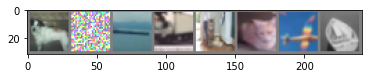

In [32]:
# 실행할 때 마다 augmentation 바뀌는거 확인
image, label = next(iter(train_loader))
grid = utils.make_grid(image)
writer.add_image('images', grid, 0)

imshow(grid)

### Step 2) 네트워크 생성

- input_dim: 입력 데이터의 차원

- hidden_dim_list: 은닉 계층의 뉴런 수

- output_dim: 결과 데이터의 차원

In [ ]:
#nn의 module을 상속받아서 그 위에 layer를 쌓아올림
#linear안에는 input, output sizef를 입력할 수 있습니다.
class MyModel(nn.Module):  #네트워크 구성 성분 입력
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=5,padding='same')
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding='same')
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding='same')
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding='same')
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding='same')
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8192,2048)
        self.batchnorm7 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048,256)
        self.batchnorm8 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,10)

    def forward(self,x):

      x = F.relu(self.batchnorm1(self.conv1(x)))
      x = F.relu(self.batchnorm2(self.conv2(x)))
      x = self.pool1(x)
      x = F.relu(self.batchnorm3(self.conv3(x)))
      x = F.relu(self.batchnorm4(self.conv4(x)))
      x = self.pool2(x)
      x = F.relu(self.batchnorm5(self.conv5(x)))
      x = self.pool3(x)
      x = self.flatten(x)
      x = F.relu(F.dropout(self.batchnorm7(self.fc1(x))))
      x = F.relu(F.dropout(self.batchnorm8(self.fc2(x))))
      x = self.fc3(x)
      return x

In [ ]:
model = MyModel()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batchnorm5): BatchNorm2d(512, eps=1e-05, momentum=0

In [ ]:
summary(model,input_size=(3,32,32))
#summary(model2,input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          51,264
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 256, 16, 16]         295,168
       BatchNorm2d-9          [-1, 256, 16, 16]             512
        MaxPool2d-10            [-1, 256, 8, 8]               0
           Conv2d-11            [-1, 512, 8, 8]       1,180,160
      BatchNorm2d-12            [-1, 512, 8, 8]           1,024
        MaxPool2d-13            [-1, 512, 4, 4]               0
          Flatten-14                 [-

### Step 3) 손실 함수 (Loss) 및 업데이트 알고리즘 (Optimizer) 설정


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)

### Step 4) 학습 (Training)

 - CIFAR-10 데이터셋을 이용하여 다층퍼셉트론을 학습시켜봅시다.

 - 학습 과정은 다음과 같습니다.

    1. 입력 (x)에 대한 결과 **예측** -> y_pred

    2. y_pred와 정답 (y_true)을 비교하여 **손실함수의 값 계산** -> criterion(y_pred, y_true)

    3. 손실함수의 값이 작아지는 방향으로 네트워크 **업데이트** -> optimizer.step()

In [ ]:
epochs = 15

for epoch in range(epochs):  
    running_loss = 0
    train_loss = 0

    for i, data in enumerate(train_loader):
        # Batch에 해당하는 Data 추출
        x, y_true = data #x는 input data에 해당 y_true는 label에
        #x = x.reshape(-1, 32*32*3) #flatten
        x = x.to(device) 
        y_true = y_true.to(device) 

        optimizer.zero_grad()
        
        # 입력에 대한 결과 예측
        y_pred = model(x)

        # 예측값과 정답을 비교하여 손실함수의 값 계산
        loss = criterion(y_pred, y_true)
        # 손실함수의 값이 작아지는 방향으로 네트워크 업데이트
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        running_loss += loss.item() #로깅용 running_loss
    train_loss /= len(train_loader)


    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
        #for i, (images,labels) in enumerate(valid_loader):
            images,labels=data
            #images = images.reshape(-1, 32*32*3)
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            writer.add_scalar("Acc/valid", val_acc, epoch)

    val_loss = val_loss / len(valid_loader)
    writer.add_scalars("Loss",{'train_loss':train_loss,'valid_loss':val_loss},epoch)
    print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))

Epoch 0, Train Loss: 2.322836803025007, Val Loss: 2.261545407652855, Val Acc: 15.03


KeyboardInterrupt: ignored

### Step 5) 성능평가 (Evaluation)

In [ ]:
def evaluation(model):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
        for data in test_loader:
            images, labels = data
            #images = images.reshape(-1, 3072)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
  return test_acc

In [ ]:
print(evaluation(model))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
!kill 294